# House Price Regression Analysis
This notebook is dedicated for practicing feature engineering the house price regression analysis. 

The steps taken to process the data is as follows:

- Impute Missingness in Continuous Data by zero coding 
- Impute Missingness in Categorical Data by label as none
- Handle Outliers using Tree-Based Discretizers
- Encode Categorical Data with mean towards target variable
- Run Several Algorithms like GB, RF and LR
- Feature Selection

# Library Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# for tree binarisation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

# to evaluate the models
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from math import sqrt

#Import stats library
import pylab 
import scipy.stats as stats

from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.externals import joblib


# Import filter warnings
import warnings
warnings.filterwarnings('ignore')


np.random.seed(100)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Variable Types

In [3]:
categorical = [var for var in train.columns if train[var].dtype =='O']
numerical = [var for var in train.columns if train[var].dtype !='O']
temporal = [i for i in train.columns if "Year" in i or "Yr" in i or "Mo" in i]

In [4]:
discrete = []

for var in numerical:
    if len(train[var].unique()) < 20 and var not in temporal:
        print(var, 'values:', train[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass values: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual values: [ 7  6  8  5  9  4 10  3  1  2]
OverallCond values: [5 8 6 7 4 2 3 9 1]
BsmtFullBath values: [1 0 2 3]
BsmtHalfBath values: [0 1 2]
FullBath values: [2 1 3 0]
HalfBath values: [1 0 2]
BedroomAbvGr values: [3 4 1 2 0 5 6 8]
KitchenAbvGr values: [1 2 3 0]
TotRmsAbvGrd values: [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces values: [0 1 2 3]
GarageCars values: [2 3 1 0 4]
PoolArea values: [  0 512 648 576 555 480 519 738]

There are 13 discrete variables


In [5]:
continuous = [i for i in numerical if i not in discrete and i not in temporal][1:-1]

In [6]:
train["ElapsedYrBlt"] = train["YrSold"] - train["YearBuilt"]
train['ElapsedYrRemodAdd'] = train["YrSold"] - train["YearRemodAdd"]
train['ElapsedYrGarageBlt'] = train["YrSold"] - train["GarageYrBlt"]
test["ElapsedYrBlt"] = test["YrSold"] - test["YearBuilt"]
test['ElapsedYrRemodAdd'] = test["YrSold"] - test["YearRemodAdd"]
test['ElapsedYrGarageBlt'] = test["YrSold"] - test["GarageYrBlt"]

temporal = [i for i in train.columns if "Elapsed" in i]

# Training and Test Split

In [7]:
# to divide train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, train.SalePrice, test_size=0.25,
                                                    random_state=0)
X_train.shape, X_test.shape

((1095, 84), (365, 84))

In [8]:
X_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Feature Engineering Missing Values

In [9]:
def check_number_null(value, type_of_var):
    if (value == 0):
        print("No more missing values in {} variables".format(type_of_var))
    else:
        print("There are still missing values that needed imputation")
    
def impute_far_end(train, variable):
    extreme = train[variable].mean() + 3 * train[variable].std()
    train[variable] = train[variable].fillna(extreme)
    test[variable] = test[variable].fillna(extreme)
    
def impute_median(train, test, variable):
    median = train[variable].median()
    train[variable] = train[variable].fillna(median)
    test[variable] = test[variable].fillna(median)
        
def impute_zero_code(train, test, variable):
    train[variable] = train[variable].fillna(0)
    test[variable] = test[variable].fillna(0)

def impute_frequent_category(train, test, variable):
    freq_category = train[variable].mode()[0]
    train[variable] = train[variable].fillna(freq_category)
    test[variable] = test[variable].fillna(freq_category)
    
def impute_missing_label(train, test, variable):
    train[variable] = train[variable].fillna("none")
    test[variable] = test[variable].fillna("none")

### i). Continuous
In handling continuous features, the missing values will be imputed with zeroes, this is done to signify that this particular feature is nonexistent, and using zero is an intuistic way to signify this missingness.

In [10]:
temp = X_train[continuous].isnull().mean() 
print(temp.where(temp > 0).dropna())

LotFrontage    0.181735
MasVnrArea     0.004566
dtype: float64


In [11]:
impute_median(X_train, X_test, "LotFrontage")
impute_zero_code(X_train, X_test, "MasVnrArea")

In [12]:
check_number_null(X_train[continuous].isnull().mean().sum(), "continuous")

No more missing values in continuous variables


### ii). Categorical Variables
In handling missing categorical variables, features that has very low missing values (<10%) will be imputed with the frequent category, this is done to prevent altering the distribution of the category. 
On the other hand, missing values with a number more than the threshold given above will be annotated as "none" so that predictive power can be sustained, meaning that missing values will be kept as a separate group.

In [13]:
temp = X_train[categorical].isnull().mean() 
print(temp.where(temp > 0).dropna())

Alley           0.940639
MasVnrType      0.004566
BsmtQual        0.022831
BsmtCond        0.022831
BsmtExposure    0.022831
BsmtFinType1    0.022831
BsmtFinType2    0.023744
Electrical      0.000913
FireplaceQu     0.475799
GarageType      0.051142
GarageFinish    0.051142
GarageQual      0.051142
GarageCond      0.051142
PoolQC          0.996347
Fence           0.818265
MiscFeature     0.957078
dtype: float64


In [14]:
## Basement
basement = [i for i in X_train[categorical] if "Bsmt" in i]
for i in basement:
    impute_missing_label(X_train, X_test, i)

## Garage
garage = [i for i in X_train[categorical] if "Garage" in i]
for i in garage:
    impute_missing_label(X_train, X_test, i)
    
## Alley
impute_missing_label(X_train, X_test, "Alley")

## MasVnrType
impute_missing_label(X_train, X_test, "MasVnrType")

## Electrical
impute_frequent_category(X_train, X_test, "Electrical")

## Fireplaces
impute_missing_label(X_train, X_test, "FireplaceQu")

## Pool
impute_missing_label(X_train, X_test, "PoolQC")

## Fence
impute_missing_label(X_train, X_test, "Fence")

## Fence
impute_missing_label(X_train, X_test, "MiscFeature")

In [15]:
check_number_null(X_train[categorical].isnull().mean().sum(), "categorical")

No more missing values in categorical variables


### ii). Discrete Variables

In [16]:
check_number_null(X_train[discrete].isnull().mean().sum(), "discrete")

No more missing values in discrete variables


### iii). Temporal Variables
In temporal variables, as we know from the EDA, the elapsed year of garage built is none due to the fact that garage is nonexistent in that particular property.

In [17]:
impute_zero_code(X_train, X_test, 'ElapsedYrGarageBlt')

In [18]:
check_number_null(X_train[temporal].isnull().mean().sum(), "temporal")

No more missing values in temporal variables


# Adding Additional Variables

In [19]:
def add_additional_comb_features(df_pipe):
    df_pipe['YrBltAndRemod']= df_pipe['YearBuilt']+df_pipe['YearRemodAdd']
    df_pipe['TotalSF']=df_pipe['TotalBsmtSF'] + df_pipe['1stFlrSF'] + df_pipe['2ndFlrSF']
    df_pipe['Total_sqr_footage'] = (df_pipe['BsmtFinSF1'] + df_pipe['BsmtFinSF2'] + df_pipe['1stFlrSF'] + df_pipe['2ndFlrSF'])
    df_pipe['Total_Bathrooms'] = (df_pipe['FullBath'] + (0.5 * df_pipe['HalfBath']) + df_pipe['BsmtFullBath'] + (0.5 * df_pipe['BsmtHalfBath']))
    df_pipe['Total_porch_sf'] = (df_pipe['OpenPorchSF'] + df_pipe['3SsnPorch'] + df_pipe['EnclosedPorch'] + df_pipe['ScreenPorch'] + df_pipe['WoodDeckSF'])
def add_additional_bool_features(df_pipe):
    df_pipe['haspool'] = df_pipe['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df_pipe['has2ndfloor'] = df_pipe['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df_pipe['hasgarage'] = df_pipe['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df_pipe['hasbsmt'] = df_pipe['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df_pipe['hasfireplace'] = df_pipe['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [20]:
add_additional_comb_features(X_train)
add_additional_comb_features(X_test)
add_additional_bool_features(X_train)
add_additional_bool_features(X_test)
added_feat = ['YrBltAndRemod', 'TotalSF', 'Total_sqr_footage','Total_Bathrooms', 'Total_porch_sf']
boolean_feat = [i for i in X_train.columns if "has" in i]
new_feat = added_feat + boolean_feat

# Handling Outliers

Due to how there are too many feature that possesses outliers, to handle this issue, there are two methods that we can implement. 

1. Transformation: We transform the data using log or box-cox transformation
2. Discretisation: We bin the values into several bins

For interpretability and ease of use, we will use decision-tree discretization to quickly bin all the values into several groups that can make better predictability due to how it can create monotonicity towards the target variables

In [21]:
def tree_binariser(var):
    score_ls = [] # here I will store the mse
    depth = [1,2,3,4]
    for tree_depth in depth:
        # call the model
        tree_model = DecisionTreeRegressor(max_depth=tree_depth)

        # train the model using 3 fold cross validation
        scores = cross_val_score(tree_model, X_train[var].to_frame(), y_train, cv=3, scoring='neg_mean_squared_error')
        score_ls.append(np.mean(scores))

    # find depth with smallest mse
    no_depth = depth[np.argmin(score_ls)]
    #print(score_ls, np.argmin(score_ls), depth)

    # transform the variable using the tree
    tree_model = DecisionTreeRegressor(max_depth = no_depth)
    tree_model.fit(X_train[var].to_frame(), y_train)
    X_train[var] = tree_model.predict(X_train[var].to_frame())
    X_test[var] = tree_model.predict(X_test[var].to_frame())

In [22]:
for var in X_train[continuous]:
    tree_binariser(var)

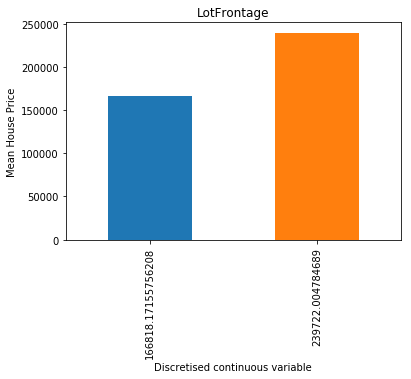

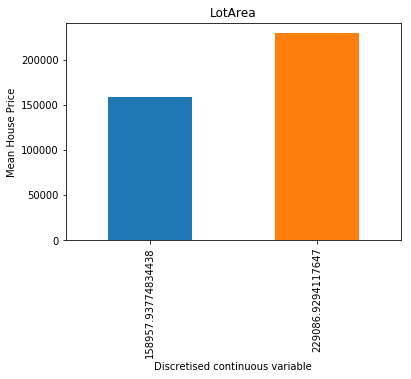

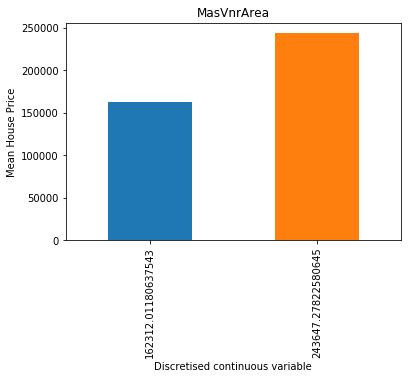

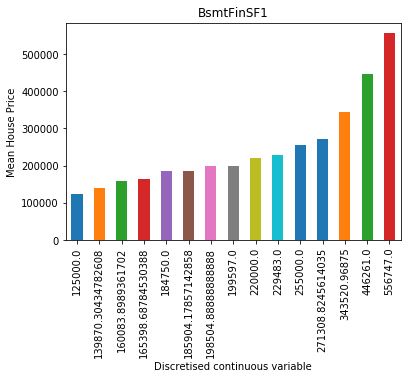

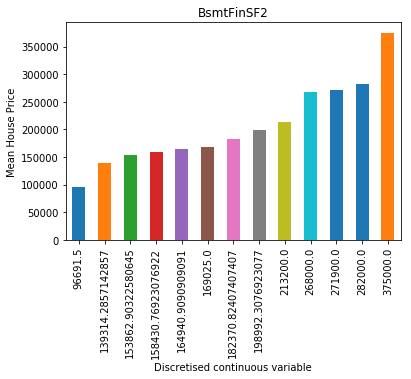

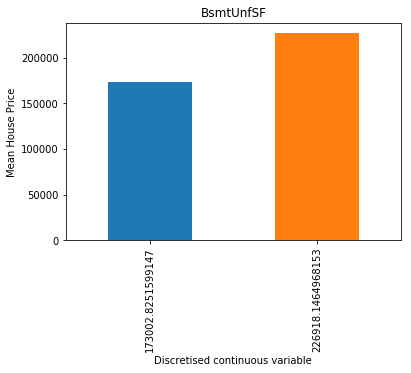

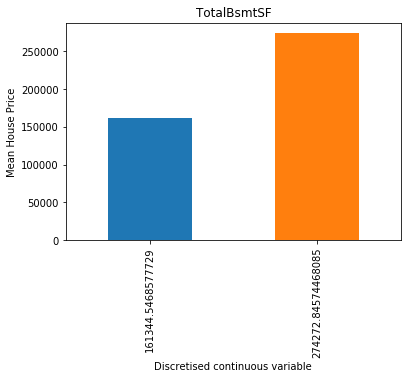

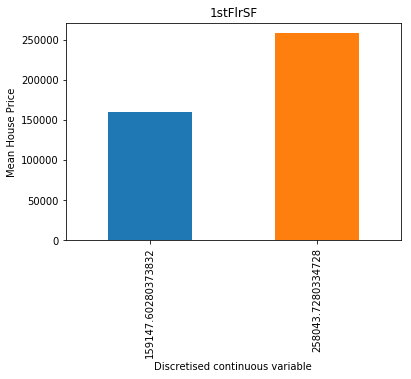

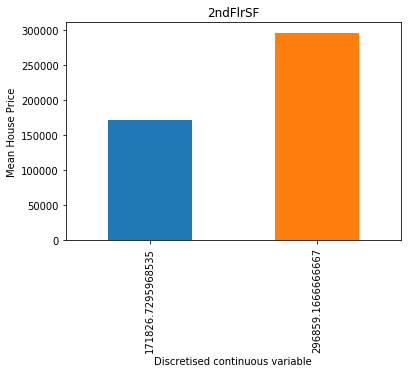

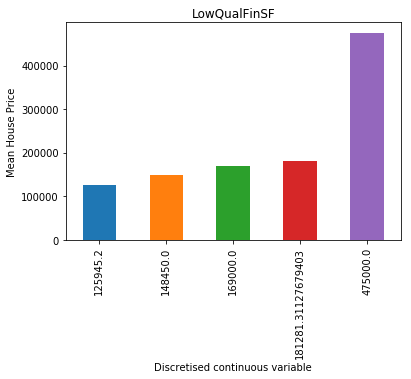

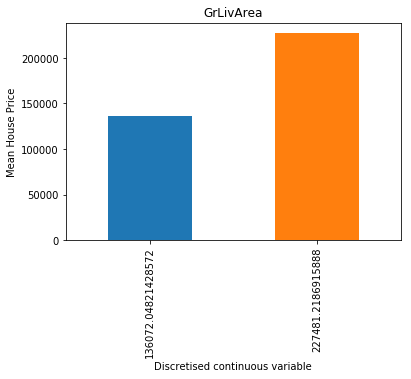

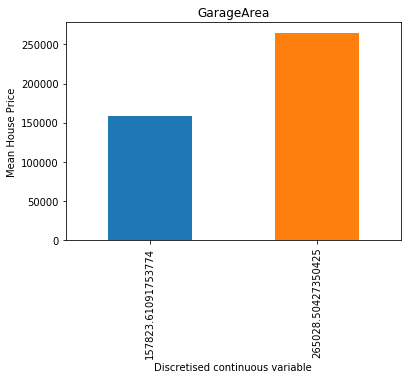

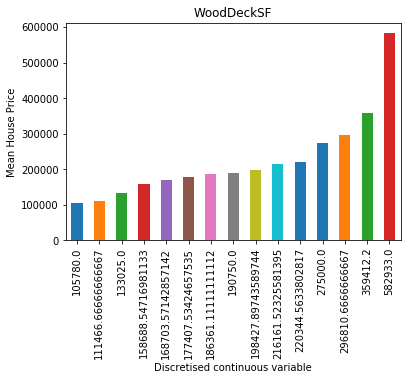

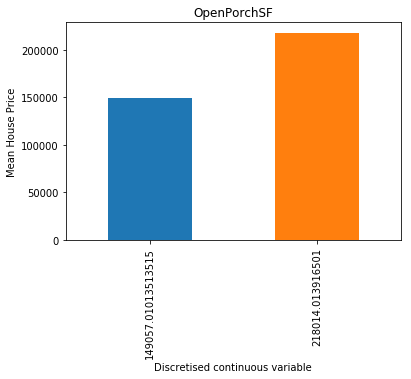

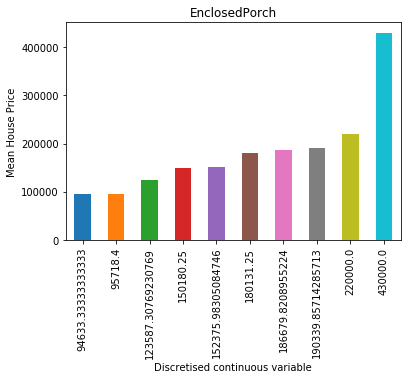

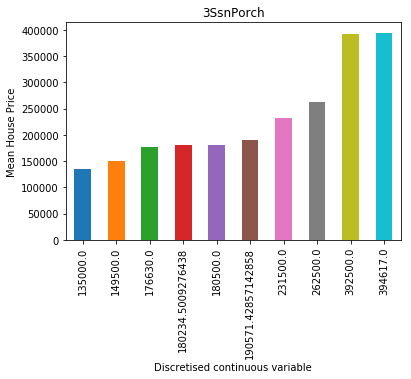

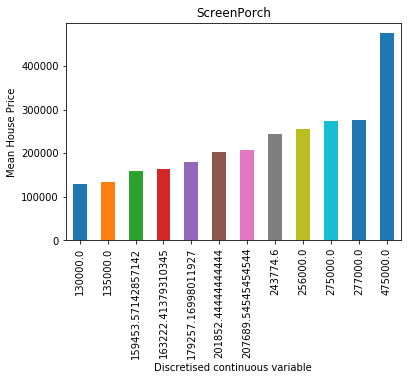

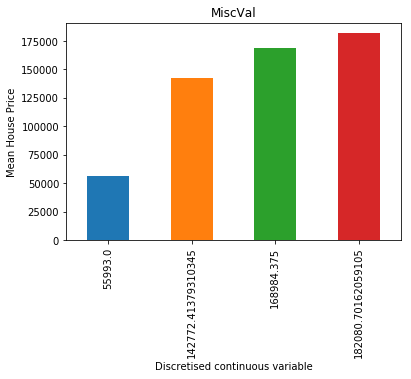

In [23]:
for var in continuous:
    X_train.groupby(var)['SalePrice'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('Mean House Price')
    plt.xlabel('Discretised continuous variable')
    plt.show()

By using Tree-Based Discretizers we can see that the outliers effect in continuous values have been suppressed as the continuous values have been binned into several value cutoff. Additionally by binning into several variables, it will give more predictive power towards the variable due to the monotonic relationship with the target variables.

## Encoding Rare Labels in Categorical and Discrete Variables

In [24]:
def impute_rare(train, test, variable):
    # find frequent labels / discrete numbers
    temp = train.groupby([variable])[variable].count()/np.float(len(X_train))
    frequent_cat = [x for x in temp.loc[temp>0.05].index.values]
    train[variable] = np.where(train[variable].isin(frequent_cat), train[variable], 'rare')
    test[variable] = np.where(test[variable].isin(frequent_cat), test[variable], 'rare')

In [25]:
for var in discrete:
    impute_rare(X_train, X_test, var)
for var in categorical:
    impute_rare(X_train, X_test, var)

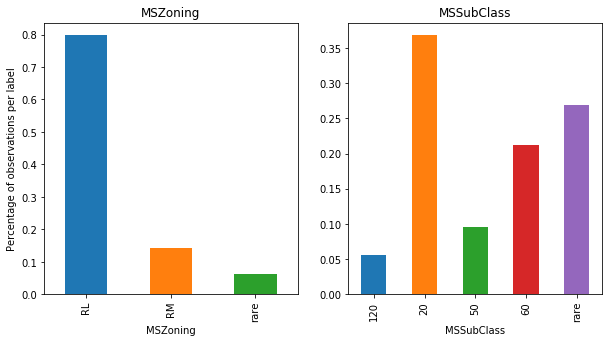

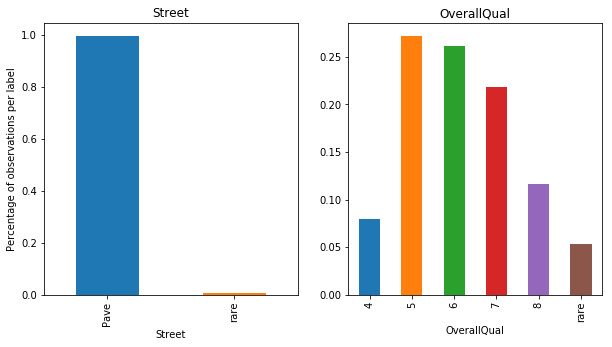

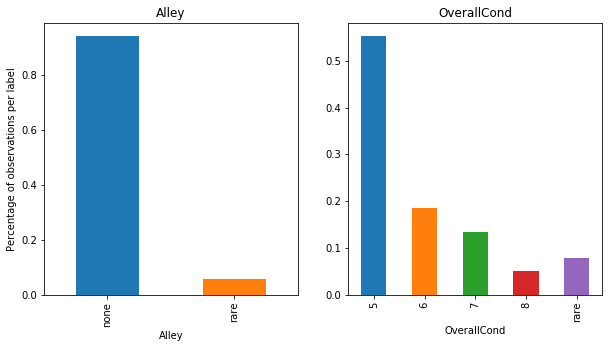

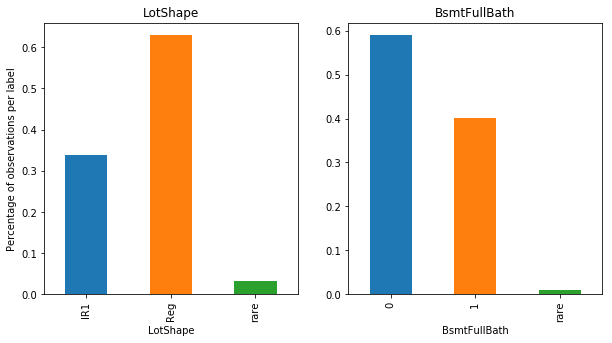

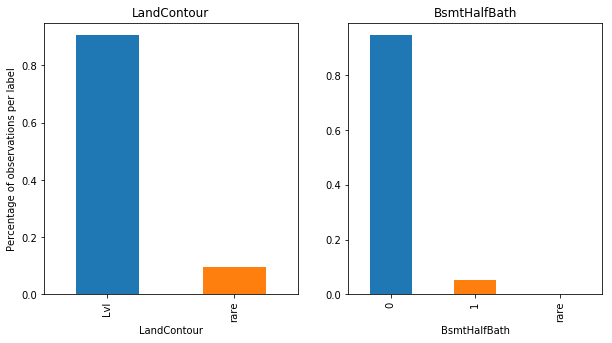

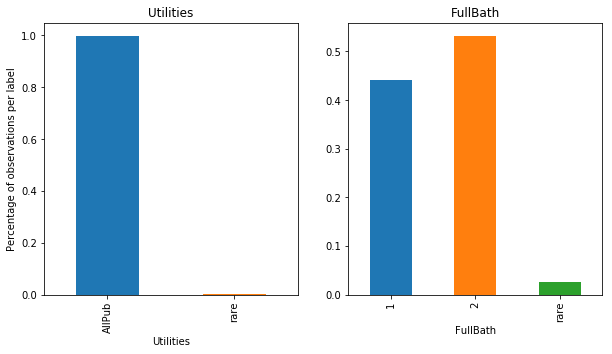

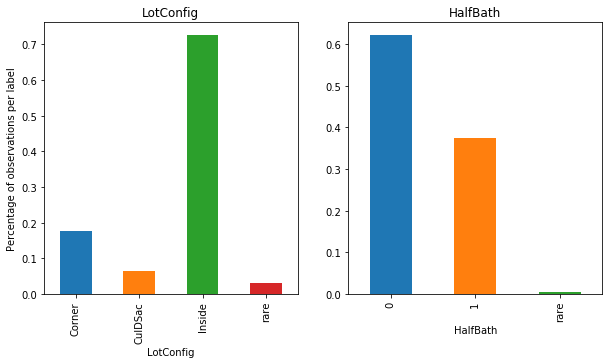

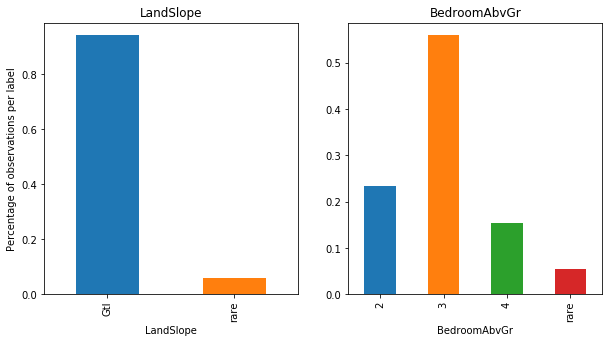

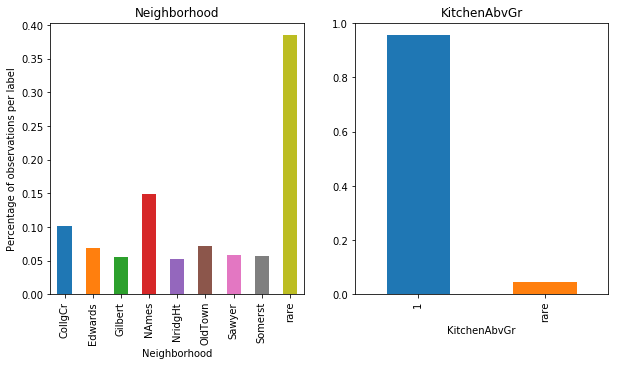

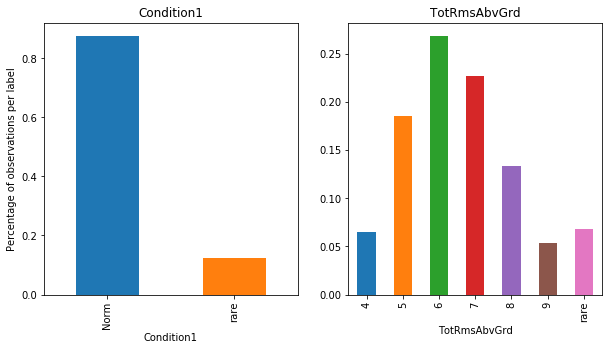

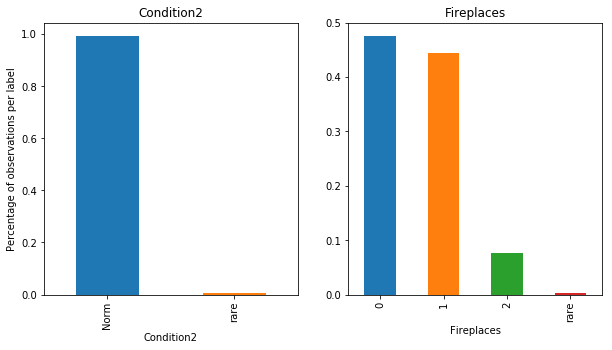

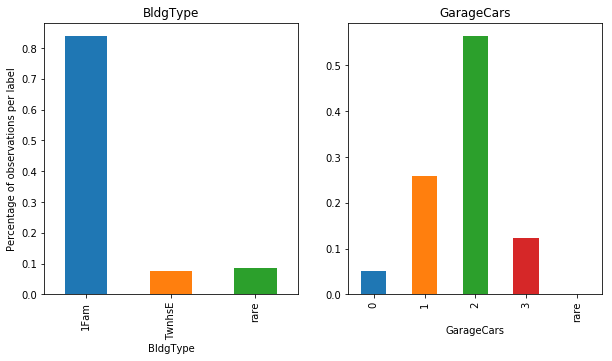

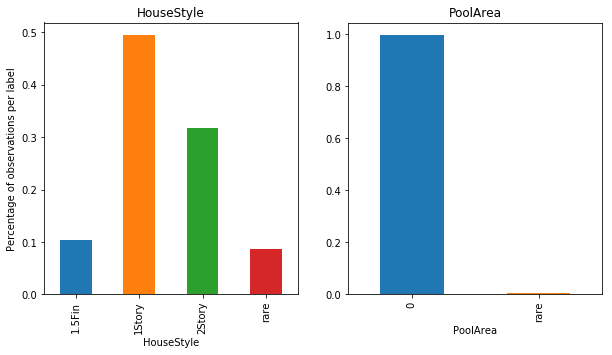

In [26]:
# let's check that it worked
for var1, var2 in zip(categorical, discrete):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    fig = (X_train.groupby(var1)[var1].count() / np.float(len(X_train))).plot.bar()
    fig.set_ylabel('Percentage of observations per label')
    fig.set_title(var1)
    
    plt.subplot(1, 2, 2)
    fig = (X_train.groupby(var2)[var2].count() / np.float(len(X_train))).plot.bar()
    fig.set_title(var2)
    plt.show()

The graph above shows that our rare encoder has worked and made the data distribution more generalized.

In [27]:
def encode_categorical_variables(var, target):
        # make label to price dictionary
        ordered_labels = X_train.groupby([var])[target].mean().to_dict()
        
        # encode variables
        X_train[var] = X_train[var].map(ordered_labels)
        X_test[var] = X_test[var].map(ordered_labels)

# encode labels in categorical vars
for var in categorical:
    encode_categorical_variables(var, 'SalePrice')
    
# encode labels in discrete vars
for var in discrete:
    encode_categorical_variables(var, 'SalePrice')

# Feature Scaling

In [28]:
training_vars = temporal + discrete + continuous + categorical + new_feat

In [29]:
# fit scaler
minmax_scaler = MinMaxScaler() # create an instance
minmax_scaler.fit(X_train[training_vars]) #  fit  the scaler to the train set for later use
robust_scaler = RobustScaler() # create an instance
robust_scaler.fit(X_train[training_vars]) #  fit  the scaler to the train set for later use
standard_scaler = StandardScaler() # create an instance
standard_scaler.fit(X_train[training_vars]) #  fit  the scaler to the train set for later use

StandardScaler(copy=True, with_mean=True, with_std=True)

# Feature Selection 

# Model Testing & Embedded Feature Selection

In [30]:
X_train["SalePrice"].mean()

180733.1497716895

# Functions

In [31]:
def print_result(y_train, train_pred, y_test, test_pred):
    print("\nResults on Training Set")
    print('xgb train rmse: {}'.format(sqrt(mean_squared_error(y_train, np.exp(train_pred)))))
    print('xgb train rmsle: {}'.format(sqrt(mean_squared_log_error(y_train, np.exp(train_pred)))))
    print('r-squared train: {}'.format(r2_score(y_train, np.exp(train_pred))))
    print("\nResults on Test Set")
    print('xgb test rmse: {}'.format(sqrt(mean_squared_error(y_test, np.exp(test_pred)))))
    print('xgb test rmsle: {}'.format(sqrt(mean_squared_log_error(y_test, np.exp(test_pred)))))
    print('r-squared test: {}'.format(r2_score(y_test, np.exp(test_pred))))
    

def run_xgb(X_train, X_test, y_train, y_test):
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train, np.log(y_train))
    train_pred = gb_model.predict(X_train)
    test_pred = gb_model.predict(X_test)
    print_result(y_train, train_pred, y_test, test_pred)
    

def run_rf(X_train, X_test, y_train, y_test):
    rf_model = RandomForestRegressor(n_estimators=900, max_depth=7)
    rf_model.fit(X_train, np.log(y_train))
    train_pred = rf_model.predict(X_train)
    test_pred = rf_model.predict(X_test)
    print_result(y_train, train_pred, y_test, test_pred)
    
    
def run_SVM(X_train, X_test, y_train, y_test, scaler):
    SVR_model = SVR()
    SVR_model.fit(scaler.transform(X_train), np.log(y_train))
    train_pred = SVR_model.predict(X_train)
    test_pred = SVR_model.predict(X_test)
    print_result(y_train, train_pred, y_test, test_pred)
    
    
def run_lasso(X_train, X_test, y_train, y_test, training_vars, scaler):
    lin_model = Lasso(alpha=0.005)
    lin_model.fit(scaler.transform(X_train), np.log(y_train))
    train_pred = lin_model.predict(scaler.transform(X_train))
    test_pred = lin_model.predict(scaler.transform(X_test))
    print_result(y_train, train_pred, y_test, test_pred)

# Baseline ML Models

### Gradient Boosting

In [32]:
run_xgb(X_train[training_vars], X_test[training_vars], y_train, y_test)


Results on Training Set
xgb train rmse: 15530.939412833995
xgb train rmsle: 0.08105500716955003
r-squared train: 0.9611469801696159

Results on Test Set
xgb test rmse: 26679.910441489927
xgb test rmsle: 0.1285409134509394
r-squared test: 0.8921801586335131


### Random Forests

In [33]:
run_rf(X_train[training_vars], X_test[training_vars], y_train, y_test)


Results on Training Set
xgb train rmse: 16972.876998511587
xgb train rmsle: 0.08801694544328789
r-squared train: 0.9535976199655734

Results on Test Set
xgb test rmse: 27873.510749943627
xgb test rmsle: 0.1336682171900463
r-squared test: 0.882317116971749


### SVM

In [34]:
run_SVM(X_train[training_vars], X_test[training_vars], y_train, y_test, minmax_scaler)


Results on Training Set
xgb train rmse: 81682.7199234524
xgb train rmsle: 0.40617998975635305
r-squared train: -0.07470609087142388

Results on Test Set
xgb test rmse: 84253.64204898705
xgb test rmsle: 0.3890696467310424
r-squared test: -0.07524472403858873


### Regularized Linear Regression

In [35]:
run_lasso(X_train[training_vars], X_test[training_vars], y_train, y_test, training_vars, minmax_scaler)


Results on Training Set
xgb train rmse: 32484.10999257538
xgb train rmsle: 0.16147754124969924
r-squared train: 0.8300303917317583

Results on Test Set
xgb test rmse: 38271.325778820334
xgb test rmsle: 0.15703687914514863
r-squared test: 0.7781410424966901


# Feature Selection Models

In [36]:
gb_model = GradientBoostingRegressor()
eval_set = [(X_test[training_vars], np.log(y_test))]
gb_model.fit(X_train[training_vars], np.log(y_train))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

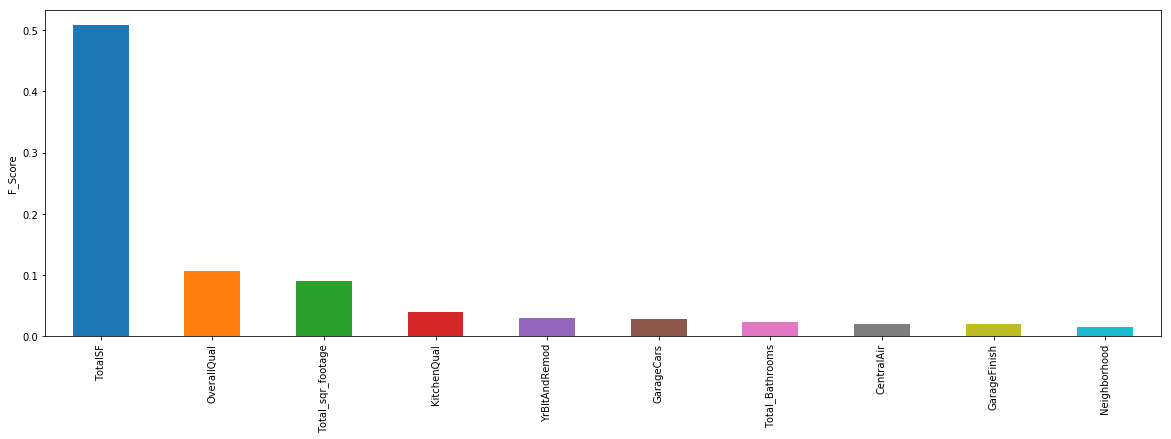

In [37]:
features = pd.Series(gb_model.feature_importances_)
features.index = X_train[training_vars].columns
# sort the features by importance
features.sort_values(ascending=False, inplace=True)
features.head(10).plot.bar(figsize=(20,6))
plt.ylabel("F_Score")
plt.show()

# Selection Based on Tree Information Gain
Feature Selection using gini index is a fast way of getting the best 

In [38]:
sel_ = SelectFromModel(GradientBoostingRegressor())
sel_.fit(X_train[training_vars], y_train)
selected_feat = X_train[training_vars].columns[(sel_.get_support())]

In [39]:
selected_feat

Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'OverallQual', 'GarageCars',
       'Neighborhood', 'BsmtQual', 'KitchenQual', 'YrBltAndRemod', 'TotalSF',
       'Total_sqr_footage', 'Total_Bathrooms'],
      dtype='object')

In [40]:
run_xgb(X_train[selected_feat], X_test[selected_feat], y_train, y_test)


Results on Training Set
xgb train rmse: 18431.372229829518
xgb train rmsle: 0.10319744597438565
r-squared train: 0.9452801789139504

Results on Test Set
xgb test rmse: 28317.77330190652
xgb test rmsle: 0.13924428478938536
r-squared test: 0.8785358388915132


# Recursive Feature Elimination
To reduce overfitting, I would like to make the model more generalized by doing dimensionality reduction (not PCA) but rather a simple technique of feature selection. I will use a recursive feature elimination, where each feature will ranked from most important to least, and from the least important feature to the most, it will try to eliminate from the lowest and try to find the best combination of features that yields the best model performance.

In [41]:
feature_dict = {}
feature_dict["no_feat"] = []
feature_dict["selected_feat"] = []
feature_dict["training_rmsle"] = []
feature_dict["testing_rmsle"] = []


for i in range(25, 5, -1):
    sel_ = RFE(GradientBoostingRegressor(), n_features_to_select= i)
    sel_.fit(X_train[training_vars], y_train)
    selected_feat_rfe = X_train[training_vars].columns[(sel_.get_support())]
   
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train[selected_feat_rfe], np.log(y_train))
    train_pred = gb_model.predict(X_train[selected_feat_rfe])
    test_pred = gb_model.predict(X_test[selected_feat_rfe])
#     run_xgb(X_train[selected_feat_rfe], X_test[selected_feat_rfe], y_train, y_test)
    feature_dict["no_feat"].append(i)
    feature_dict["selected_feat"].append(selected_feat_rfe)
    feature_dict["training_rmsle"].append(sqrt(mean_squared_log_error(y_train, np.exp(train_pred))))
    feature_dict["testing_rmsle"].append(sqrt(mean_squared_log_error(y_test, np.exp(test_pred))))

pd.DataFrame(feature_dict)

,no_feat,selected_feat,training_rmsle,testing_rmsle
0,25,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'O...",0.088706,0.129101
1,24,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'E...",0.087650,0.129482
2,23,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'O...",0.089588,0.131307
3,22,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'E...",0.089319,0.134026
4,21,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'O...",0.090231,0.134454
5,20,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'O...",0.091392,0.137170
6,19,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'E...",0.093247,0.136110
7,18,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'O...",0.094469,0.134030
8,17,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'O...",0.096524,0.135394
9,16,"Index(['ElapsedYrBlt', 'ElapsedYrRemodAdd', 'O...",0.096329,0.135345


In [51]:
feature_df = pd.DataFrame(feature_dict)
feature_df["margin"] = np.abs(feature_df["training_rmsle"] - feature_df["testing_rmsle"])
feature_df = feature_df[feature_df["margin"] == min(list(feature_df["margin"]))]
selected_feat = feature_df["selected_feat"].values[0]

In [52]:
run_xgb(X_train[selected_feat], X_test[selected_feat], y_train, y_test)


Results on Training Set
xgb train rmse: 20060.60308951693
xgb train rmsle: 0.11340873794688573
r-squared train: 0.935178765280347

Results on Test Set
xgb test rmse: 27466.453925850772
xgb test rmsle: 0.14301922799652636
r-squared test: 0.8857292336308997


Despite not having that much improvement, we have found an optimized model that has lower margin of difference in its training and testing performance, therefore it will be less likely to overfit the data when compared to the baseline models.

# Saving the Model

In [53]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train[selected_feat], np.log(y_train))
joblib.dump(gb_model, 'model.pkl')

['model.pkl']